# Text-to-Speech using Tacotron2

Tacotron 2 is an advanced text-to-speech (TTS) system developed by Google that converts written text into natural-sounding speech. Combining deep learning techniques, Tacotron 2 leverages a sequence-to-sequence model with attention mechanisms to generate mel-spectrograms from text input. 

## Load Tacotron2Model

In [10]:
# Load the Tacotron2Model
from nemo.collections.tts.models import Tacotron2Model
from nemo.collections.tts.models.base import SpectrogramGenerator

# Let's see what pretrained models are available
print(Tacotron2Model.list_available_models())

[PretrainedModelInfo(
	pretrained_model_name=tts_en_tacotron2,
	description=This model is trained on LJSpeech sampled at 22050Hz, and can be used to generate female English voices with an American accent.,
	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_tacotron2/versions/1.10.0/files/tts_en_tacotron2.nemo,
	class_=<class 'nemo.collections.tts.models.tacotron2.Tacotron2Model'>
)]


In [11]:
# We can load the pre-trained model as follows
model = Tacotron2Model.from_pretrained("tts_en_tacotron2")

[NeMo I 2024-09-23 01:17:26 nemo_logging:381] Found existing object /home/levi/.cache/torch/NeMo/NeMo_1.23.0/tts_en_tacotron2/319a832e78fac50399d90aee0f083927/tts_en_tacotron2.nemo.
[NeMo I 2024-09-23 01:17:26 nemo_logging:381] Re-using file from: /home/levi/.cache/torch/NeMo/NeMo_1.23.0/tts_en_tacotron2/319a832e78fac50399d90aee0f083927/tts_en_tacotron2.nemo
[NeMo I 2024-09-23 01:17:26 nemo_logging:381] Instantiating model from pre-trained checkpoint


 NeMo-text-processing :: INFO     :: Creating ClassifyFst grammars.
[NeMo W 2024-09-23 01:17:47 nemo_logging:393] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2024-09-23 01:17:48 nemo_logging:393] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /raid/datasets/tts_data/train_manifest.json
      sample_rate: 22050
      sup_data_path: null
      sup_data_types: null
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null

[NeMo I 2024-09-23 01:17:48 nemo_logging:381] PADDING: 16
[NeMo I 2024-09-23 01:17:48 nemo_logging:381] STFT using exact pad
[NeMo I 2024-09-23 01:17:48 nemo_logging:381] Model Tacotron2Model was successfully restored from /home/levi/.cache/torch/NeMo/NeMo_1.23.0/tts_en_tacotron2/319a832e78fac50399d90aee0f083927/tts_en_tacotron2.nemo.


## Tacotron2Model Text-to-Speech

[NeMo W 2024-09-23 01:18:05 nemo_logging:393] parse() is meant to be called in eval mode.


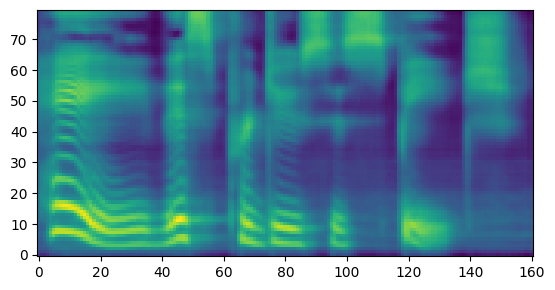

In [12]:
# Tacotron2 is a SpectrogramGenerator
assert isinstance(model, SpectrogramGenerator)

# SpectrogramGenerators in NeMo have two helper functions:
#   1. parse(self, text: str, normalize=True) which takes an English string and produces a token tensor
#   2. generate_spectrogram(self, *, tokens) which takes the token tensor and generates a spectrogram
# Let's try it out
tokens = model.parse(text = "Hey, this produces speech!")
spectrogram = model.generate_spectrogram(tokens = tokens)

# Now we can visualize the generated spectrogram
# If we want to generate speech, we have to use a vocoder in conjunction to a spectrogram generator.
# Refer to the TTS Inference notebook on how to convert spectrograms to speech.
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
%matplotlib inline
imshow(spectrogram.cpu().detach().numpy()[0,...], origin="lower")
plt.show()

## Training a Tacotron2Model

NeMo's training scripts are stored inside the examples/ folder. Let's grab the tacotron2.py file as well as the tacotron2.yaml file

In [4]:
BRANCH = 'main'
!wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/tacotron2.py
!(mkdir -p conf \
  && cd conf \
  && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/conf/tacotron2.yaml \
  && cd ..)

# download tacotron2.py and conf

--2024-09-22 17:13:35--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/tts/tacotron2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1874 (1.8K) [text/plain]
Saving to: ‘tacotron2.py’

tacotron2.py        100%[===================>]   1.83K  --.-KB/s    in 0s      

2024-09-22 17:13:35 (10.5 MB/s) - ‘tacotron2.py’ saved [1874/1874]

--2024-09-22 17:13:35--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/tts/conf/tacotron2.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5338 (5.2K) [text/plain]
Sav

We will also need a few extra files for handling text.

In [5]:
!(mkdir -p scripts/tts_dataset_files \
  && cd scripts/tts_dataset_files \
  && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/tts_dataset_files/cmudict-0.7b_nv22.10 \
  && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/tts_dataset_files/heteronyms-052722 \
  && cd ..)

# download scripts

--2024-09-22 17:13:58--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/scripts/tts_dataset_files/cmudict-0.7b_nv22.10
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3741429 (3.6M) [text/plain]
Saving to: ‘cmudict-0.7b_nv22.10’

cmudict-0.7b_nv22.1 100%[===================>]   3.57M  8.37MB/s    in 0.4s    

2024-09-22 17:13:59 (8.37 MB/s) - ‘cmudict-0.7b_nv22.10’ saved [3741429/3741429]

--2024-09-22 17:13:59--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/scripts/tts_dataset_files/heteronyms-052722
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaitin

After adjusting your configuration in `./conf/tacotron2.yaml`, you simply need to run `tacotron2.py` to start training your Tacotron 2 model. Here is the code inside `tacotron2.py`. You can run the following cell.

train_dataset: ???
validation_datasets: ???

In [25]:
!(python tacotron2.py \
  model.sample_rate=16000 \
  train_dataset=./LJSpeech/train/train.json \
  validation_datasets=./LJSpeech/valid/valid.json \
  trainer.max_epochs=3 \
  trainer.accelerator='cpu')

[NeMo W 2024-09-23 01:48:06 nemo_logging:393] /home/levi/Speech-Course-Lab/env/lib/python3.11/site-packages/megatron/core/tensor_parallel/layers.py:253: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
      @custom_fwd
    
[NeMo W 2024-09-23 01:48:06 nemo_logging:393] /home/levi/Speech-Course-Lab/env/lib/python3.11/site-packages/megatron/core/tensor_parallel/layers.py:264: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
      @custom_bwd
    
[NeMo W 2024-09-23 01:48:06 nemo_logging:393] /home/levi/Speech-Course-Lab/env/lib/python3.11/site-packages/megatron/core/tensor_parallel/layers.py:324: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
      @custom_fwd
    
[NeMo W 2024-09-23 01:48:06 nemo_logging:393] /home/lev